### Tabular Data with Random Forest - [notebook](https://github.com/fastai/fastbook/blob/master/09_tabular.ipynb)

**Todos**
*   Remove split_param = random from the Data Bundle, after making that the default in data_lib

### Import KD Libraries

In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import IPython.core.debugger as db
from pathlib import Path
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
gd_path = 'gdrive/My Drive/Colab Data/fastai-v3'  #change dir to your project folder
gn_path = 'gdrive/My Drive/Colab Notebooks'  #change dir to your project folder

import sys
sys.path.insert(1, gn_path + '/exp')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
from nb_util import save_pickle, load_pickle
from nb_data import TabularDataBundle, FeatureSet, FeatureList
from nb_app import AppTabular

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Obsolete

In [ ]:
import torch
from torch import nn
from functools import partial



import torch.nn.functional as F
import torch.optim as optim


In [ ]:
from nb_util import DebugRand
from nb_app import AppBase, ArchTabular

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Data Bundle

In [ ]:
#----------------------------------------------------
# Bluebook for Bulldozers data preparation pipeline
#----------------------------------------------------
class TabularBluebookDataBundle(TabularDataBundle):
  def __init__(self, csv_path, test_csv_path, related_csv_paths, **kwargs):
    bb_ordinal_vals={'ProductSize': ['Large','Large / Medium','Medium','Small','Mini','Compact']}
    super().__init__(csv_path, test_csv_path, related_csv_paths, prepare_fn=self.prepare, test_data=True, add_flag=True, ordinal_vals=bb_ordinal_vals)
    self.split_params = {'split_procedure': 'split_custom', 'custom_fn': self.split_date}
    # Remove the Normalise converter
    self.convert_x_params = [cxp for cxp in self.convert_x_params if cxp['convert_procedure'] not in ['normalise']]

  # ----------------------------
  # Split the data based on a cutoff date. All rows earlier than the cutoff date are taken
  # as training data, and rows later than the Date are taken as validation data.
  # The cutoff date is chosen based on the duration of the test data, since we want the 
  # duration of the validation data to be similar to the duration of the test data.
  # ----------------------------   
  def split_date(self):
    # Get train df
    train_df = self.all_rows.df

    # We know that the test data covers a six-month period from May 2012, and the training data 
    # ends in April 2012. So we take the validation data from November 2011 - April 2012, and 
    # the training data before November 2011
    cond = (train_df['saleYear'] < 2011) | (train_df['saleMonth'] < 10)
    train_idxs = list(np.where( cond)[0])
    valid_idxs = list(np.where(~cond)[0])

    # Get the ItemLists of rows corresponding to those indexes
    train_rows, valid_rows, test_rows = self.all_rows.split_idxs(test_data=True, train_idxs=train_idxs, valid_idxs=valid_idxs)

    return (train_rows, valid_rows, test_rows)

  # ----------------------------
  # Basic training columns
  # ----------------------------   
  def _prepare_base(self, il):
    # Extract all Date metadata columns from the 'Date' column
    il.extract_date(col='saledate', drop=False)

    # Some 'YearMade' values are set to the year 1000 which are actually just a missing 
    # value placeholder. Replace it with 1950.
    il.df.loc[il.df['YearMade'] < 1900, 'YearMade'] = 1950

    #base_cat_cols = ['state', 'ProductGroup', 'Drive_System', 'Enclosure', 'saleYear', 'saleMonth']
    base_cat_cols = ['UsageBand', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
                     'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state', 'ProductGroup',
                     'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
                     'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
                     'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control',
                     'Tire_Size', 'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
                     'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer', 'Grouser_Type',
                     'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls', 'Differential_Type', 'Steering_Controls',
                     'saleIs_month_end', 'saleIs_month_start', 'saleIs_quarter_end', 'saleIs_quarter_start',
                     'saleIs_year_end', 'saleIs_year_start', 'saleElapsed']
    base_cont_cols = ['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID', 'YearMade', 
                      'MachineHoursCurrentMeter', 'saleYear', 'saleMonth', 'saleWeek', 'saleDay',
                      'saleDayofweek', 'saleDayofyear']

    fs = FeatureSet('base', base_cat_cols, base_cont_cols)
    return (fs)

  # ----------------------------
  # Target columns
  # ----------------------------   
  def _prepare_tgt(self, il, is_test):
    cols_tgt=['SalePrice']

    if (is_test):
      # Since the test data has no Target columns, add Target columns with dummy
      # data so that the same 'y' Extract and Convert logic that is used for the
      # training and validation data can be used for the test data
      for col in cols_tgt:
        il.df[col] = 1

    else:
      # Take log of the target columns
      il.df.loc[:, cols_tgt] = np.log(il.df[cols_tgt], dtype=np.float32)

    return cols_tgt

  # ----------------------------
  # Prepare and pre-process the data
  # ----------------------------   
  def prepare(self, il, is_test=False):
    fl = FeatureList()
    fs = self._prepare_base(il)
    fl.add_fs(fs)

    cols_tgt = self._prepare_tgt(il, is_test)

    il = super().prepare(il, fl, cols_tgt)
    return il


### Define data paths

In [ ]:
app_dir='bluebook'

root_path = Path.cwd()
download_path = root_path/app_dir
data_path = download_path

main_file_path = data_path/'TrainAndValid.csv'
test_file_path = data_path/'Test.csv'
related_csv_paths = []

pickle_dir = root_path/'pickle'

### Download Data

In [ ]:
def kaggle_data(data_name, file_dir):
  # Run this cell and select the kaggle.json file downloaded
  # from the Kaggle account settings page.
  from google.colab import files
  files.upload()

  # Let's make sure the kaggle.json file is present.
  !ls -lha kaggle.json

  # The Kaggle API client expects this file to be in ~/.kaggle,
  # so move it there.
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/

  # This permissions change avoids a warning on Kaggle tool startup.
  !chmod 600 ~/.kaggle/kaggle.json

  # Install the Kaggle API client
  !pip install kaggle

  from kaggle import api
  api.competition_download_cli(data_name, path=file_dir)

In [ ]:
kaggle_data_name = 'bluebook-for-bulldozers'
kaggle_data(kaggle_data_name, root_path)

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 66 Sep  3 12:33 kaggle.json


 10%|█         | 5.00M/48.4M [00:00<00:01, 40.7MB/s]

100%|██████████| 48.4M/48.4M [00:00<00:00, 60.6MB/s]

In [ ]:
def bluebook_extract(zip_file, out_path):
  !zipinfo {zip_file}

  !unzip {zip_file} -d {out_path} >> /dev/null
  !ls -l {out_path}

bluebook_extract(f'{kaggle_data_name}.zip', data_path)

Archive:  bluebook-for-bulldozers.zip
Zip file size: 50792941 bytes, number of entries: 14
-rw----     5.1 fat    11063 bx defN 19-Dec-11 04:05 Data Dictionary.xlsx
-rw----     5.1 fat 51498702 bx defN 19-Dec-11 04:05 Machine_Appendix.csv
-rw----     5.1 fat  3560907 bx defN 19-Dec-11 04:05 Test.csv
-rw----     5.1 fat  7183499 bx defN 19-Dec-11 04:05 Train.7z
-rw----     5.1 fat  9732240 bx defN 19-Dec-11 04:05 Train.zip
-rw----     5.1 fat  7403772 bx defN 19-Dec-11 04:05 TrainAndValid.7z
-rw----     5.1 fat 119791159 bx defN 19-Dec-11 04:05 TrainAndValid.csv
-rw----     5.1 fat 10057248 bx defN 19-Dec-11 04:05 TrainAndValid.zip
-rw----     5.1 fat   214480 bx defN 19-Dec-11 04:05 Valid.7z
-rw----     5.1 fat  3318969 bx defN 19-Dec-11 04:05 Valid.csv
-rw----     5.1 fat   303660 bx defN 19-Dec-11 04:05 Valid.zip
-rw----     5.1 fat   323524 bx defN 19-Dec-11 04:05 ValidSolution.csv
-rw----     5.1 fat   196760 bx defN 19-Dec-11 04:05 median_benchmark.csv
-rw----     5.1 fat   211941

### Exploratory Data Analysis

In [ ]:
bbdb = TabularDataBundle(main_file_path, related_csv_paths=related_csv_paths)
train_il = bbdb.process(steps=['load'])

--------- Tabular Home Credit DataBundle init /content/bluebook/TrainAndValid.csv None []
/content/bluebook/TrainAndValid.csv memory reduced by 9.2% from 166.88 MB to 151.53 MB
DfItemList init with 412698 items, 151.53 df memory, 3.54 items memory
CSVItemContainer loaded 412698 items of type TabularItemList


In [ ]:
train_il.df.sample()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
229483,1721477,39500.0,1340267,2160,132,8.0,2003,NaN,NaN,9/15/2010 0:00,SK330LC,SK330,NaN,NaN,LC,Large / Medium,"Hydraulic Excavator, Track - 33.0 to 40.0 Metr...",Mississippi,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN


In [ ]:
train_il.df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

### Load Data

In [ ]:
bb_app = AppTabular()
bb_app.load_data(TabularBluebookDataBundle, main_file_path, test_file_path, related_csv_paths=None, steps=['load'])
save_pickle(bb_app, pickle_dir, 'prep_data.pkl')

--------- Tabular Home Credit DataBundle init /content/bluebook/TrainAndValid.csv /content/bluebook/Test.csv None
/content/bluebook/TrainAndValid.csv memory reduced by 9.2% from 166.88 MB to 151.53 MB
DfItemList init with 412698 items, 151.53 df memory, 3.54 items memory
DfItemList init with 412698 items, 51.28 df memory, 3.54 items memory
/content/bluebook/Test.csv memory reduced by 9.1% from 4.94 MB to 4.49 MB
DfItemList init with 12457 items, 4.49 df memory, 0.11 items memory
DfItemList init with 12457 items, 1.69 df memory, 0.11 items memory
CSVItemContainer loaded 412698 items of type TabularItemList


In [ ]:
bb_app = load_pickle(pickle_dir/'prep_data.pkl')
bb_app.load_data(None, None, None, None, steps=['post_load'])
save_pickle(bb_app, pickle_dir, 'proc_data.pkl')

ItemList split_custom <bound method TabularBluebookDataBundle.split_date of <__main__.TabularBluebookDataBundle object at 0x7f2e02100978>>
DfItemList init with 404710 items, 50.30 df memory, 3.47 items memory
DfItemList init with 7988 items, 1.49 df memory, 0.07 items memory
Split using split_custom into 404710, 7988 and 12457 items of type TabularItemList
DfItemList init with 404710 items, 48.75 df memory, 3.47 items memory
Extracted 404710 items of type TabularItemList using extract_type
DfItemList init with 404710 items, 1.54 df memory, 3.47 items memory
Extracted 404710 items of type TabularItemList using extract_type
Converted 404710 items to type TabularItemList using remove_inf
Column MachineHoursCurrentMeter has 0.6442514393022164 percent missing rows. In Train: True
Converted 404710 items to type TabularItemList using check_missing
Converted 404710 items to type TabularItemList using fill_missing
Converted 404710 items to type TabularItemList using to_cat


gdrive/My Drive/Colab Notebooks/exp/nb_data.py:2882: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if (not np.issubdtype(arr.dtype, float)):


Converted 404710 items to type TabularItemList using to_np
Converted 404710 items to type TabularItemList using to_np
DfItemList init with 7988 items, 1.46 df memory, 0.07 items memory
Extracted 7988 items of type TabularItemList using extract_type
DfItemList init with 7988 items, 0.03 df memory, 0.07 items memory
Extracted 7988 items of type TabularItemList using extract_type
Converted 7988 items to type TabularItemList using remove_inf
Column MachineHoursCurrentMeter has 0.5582123184777166 percent missing rows. In Train: False
Converted 7988 items to type TabularItemList using check_missing
Converted 7988 items to type TabularItemList using fill_missing
Converted 7988 items to type TabularItemList using to_cat
Converted 7988 items to type TabularItemList using to_np
Converted 7988 items to type TabularItemList using to_np
DfItemList init with 12457 items, 1.59 df memory, 0.11 items memory
Extracted 12457 items of type TabularItemList using extract_type
DfItemList init with 12457 item

### Create Decision Tree

In [ ]:
train_x, train_y = bb_app.db.train_ds.x.df, bb_app.db.train_ds.y.df.iloc[:, 0]
valid_x, valid_y = bb_app.db.valid_ds.x.df, bb_app.db.valid_ds.y.df.iloc[:, 0]

In [ ]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(train_x, train_y);

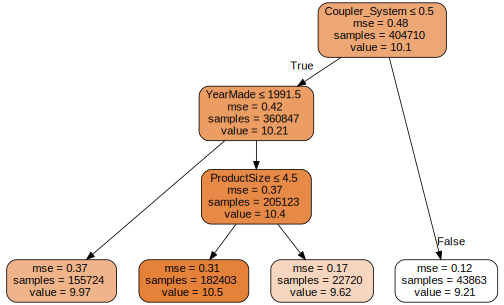

In [ ]:
# import the export_graphviz exporter 
from sklearn.tree import export_graphviz
import graphviz
import re

def draw_tree(t, df, size=10, ratio=0.6, precision=0, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

draw_tree(m, train_x, size=7, leaves_parallel=True, precision=2)

In [ ]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [ ]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(train_x, train_y)
m_rmse(m, train_x, train_y), m_rmse(m, valid_x, valid_y), m.get_n_leaves()

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=25, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

(0.211706, 0.268875, 12400)

### Create Random Forest

In [ ]:
# Create a Random Forest
# n_estimators - number of trees.
# max_samples - how many rows to sample for training each tree.
# max_features - how many columns to sample at each split point (where 0.5 means "take half the total number of columns"). 
# min_samples_leaf - specify when to stop splitting the tree nodes, thus limiting the depth of the tree.
# n_jobs=-1 - tells sklearn to use all our CPUs to build the trees in parallel. 

# An important property of random forests is that they aren't very sensitive to the 
# hyperparameter choices, such as max_features. max_features=0.5 and min_samples_leaf=4 both 
# tend to work well, although sklearn's defaults work well too.
#
# The most important hyperparameter is n_estimators. Set it to as high a number as you have 
# time to train—the more trees you have, the more accurate the model will be.

def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):

    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

m = rf(train_x, train_y)
m_rmse(m, train_x, train_y), m_rmse(m, valid_x, valid_y)

(0.171292, 0.232143)

In [ ]:
# Get the predictions from each individual tree in our forest the estimators_ attribute...
preds = np.stack([t.predict(valid_x) for t in m.estimators_])
preds.shape

# ... and get the mean of those predictions. It gives the same results as our random forest.
r_mse(preds.mean(0), valid_y)

(40, 7988)

0.232143

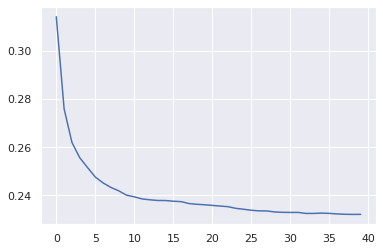

In [ ]:
# Plot RMSE as we add more and more trees. Improvement levels off after around 30 trees.
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)])

### Out-of-Bag Error

In [ ]:
# In a random forest, each tree is trained on a different subset of the training data. The OOB error 
# is a way of measuring prediction error on the training set by only including in the calculation of 
# a row's error trees where that row was not included in training. This allows us to see whether 
# the model is overfitting, without needing a separate validation set. In other words it is as
# though every tree has its own validation set viz. the rows which were not selected to train that tree.
#
# The OOB predictions are available in the oob_prediction_ attribute, when the oob_score parameter is True.
# This prediction is the 'majority' prediction of each row from all the trees where it is excluded.
m.oob_prediction_.shape, train_y.shape
r_mse(m.oob_prediction_, train_y)

((404710,), (404710,))

0.211221

### Model Interpretation  Tree Variance for Prediction Confidence

In [ ]:
# How confident are we in our predictions using a particular row of data?
# The model averages the individual tree's predictions to get an overall prediction ie. an 
# estimate of the value. To get the confidence of the estimate, we can use the standard 
# deviation of predictions across the trees, instead of just the mean. This tells us the 
# relative confidence of predictions. In general, we would want to be more cautious of 
# using the results for rows where trees give very different results (higher standard 
# deviations), compared to cases where they are more consistent (lower standard deviations)

# Get Predictions, as before, for every tree and every row in the validation set.
preds = np.stack([t.predict(valid_x) for t in m.estimators_])
# Get the standard deviation of the predictions over all the trees, for each row
preds_std = preds.std(0)

preds_std[:5]

array([0.239462, 0.127694, 0.088548, 0.237112, 0.125546])

### Model Interpretation - Feature Importance

In [ ]:
# Use Feature Importances to see which columns are the strongest predictors, and which we can ignore.

# The feature importance algorithm loops through each tree, and then recursively explores each 
# branch. At each branch, it looks to see what feature was used for that split, and how much the 
# model improves as a result of that split. The improvement (weighted by the number of rows in 
# that group) is added to the importance score for that feature. This is summed across all 
# branches of all trees, and finally the scores are normalized such that they add to 1.

# Get the _feature_importances attribute and sort them
def rf_feat_importance(m, df):
  return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

fi = rf_feat_importance(m, train_x)

# The first few most important columns have much higher importance scores than the rest
# The YearMade and ProductSize features are the most important.
fi[:10]

,cols,imp
56,YearMade,0.175012
30,Coupler_System,0.121362
6,ProductSize,0.117190
7,fiProductClassDesc,0.067163
53,ModelID,0.056253
50,saleElapsed,0.051677
3,fiSecondaryDesc,0.047411
31,Grouser_Tracks,0.045939
12,Enclosure,0.037802
1,fiModelDesc,0.036240


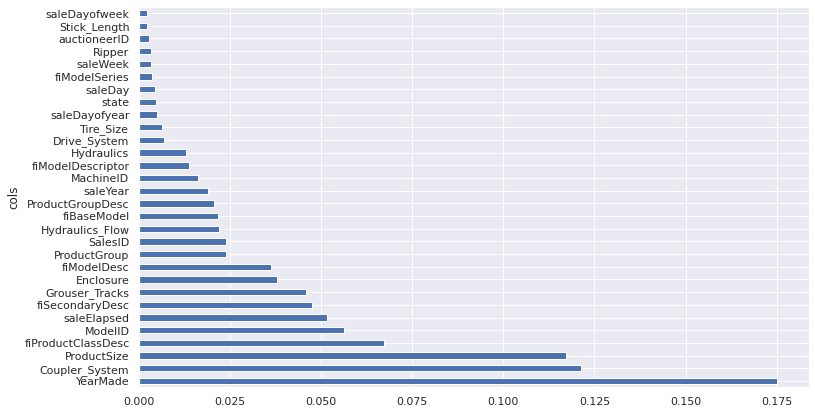

In [ ]:
def plot_fi(fi):
  return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

### Model Interpretation - Remove Low-Importance Variables

In [ ]:
# Remove the variables of low importance and still get good results. 

# Keeping those with a feature importance greater than 0.005
to_keep = fi[fi.imp>0.005].cols

# retrain our model using just this subset of the columns
train_x_imp = train_x[to_keep]
valid_x_imp = valid_x[to_keep]
m = rf(train_x_imp, train_y)

# Results show that accuracy is about the same, but we have far fewer columns to study
m_rmse(m, train_x_imp, train_y), m_rmse(m, valid_x_imp, valid_y)
len(to_keep), len(train_x.columns), len(train_x_imp.columns)

(0.181069, 0.230551)

(21, 66, 21)

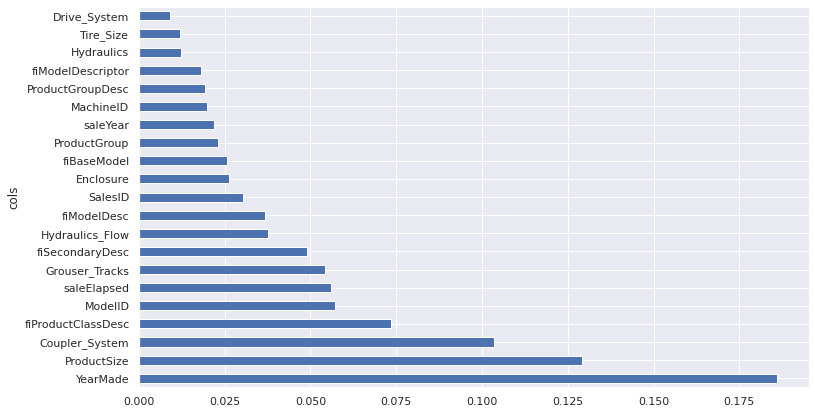

In [ ]:
plot_fi(rf_feat_importance(m, train_x_imp))

### Model Interpretation - Remove Redundant Features

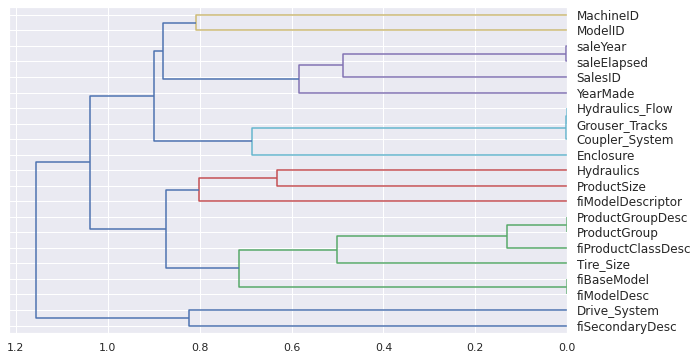

In [ ]:
# Which columns are effectively redundant with each other, for purposes of prediction?
# Some variables seem to have very similar meanings eg. ProductGroup and ProductGroupDesc.

import scipy
from scipy.cluster import hierarchy as hc

def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()


# In this chart, pairs of columns that are similar are merged together going from 
# right to left. The pairs of columns that are most similar are the ones that were 
# merged together early, on the far right. 
# The fields ProductGroup and ProductGroupDesc were merged at the very beginning - see
# the short vertical line next to those two fields. Similarly, see the vertical line
# at saleYear and saleElapsed, as well as at fiModelDesc and fiBaseModel
cluster_columns(train_x_imp)

In [ ]:
# Return the OOB score, which ranges between 1.0 for a perfect model and 0.0 for 
# a random model. We just want something quick which we can use to compare different
# models, so it doesn't have to be very accurate
def get_oob(xs, y):
  m = rf(xs, y, min_samples_leaf=15, max_samples=50000)
  return m.oob_score_

get_oob(train_x_imp, train_y)

0.8773140033526184

In [ ]:
# try removing each of our potentially redundant variables, one at a time
dup_cols = ('saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup', 'fiModelDesc', 'fiBaseModel', 'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')
{c:get_oob(train_x_imp.drop(c, axis=1), train_y) for c in dup_cols}

{'Coupler_System': 0.877084518805368,
 'Grouser_Tracks': 0.8776134487889817,
 'Hydraulics_Flow': 0.878532272889271,
 'ProductGroup': 0.8775279035805577,
 'ProductGroupDesc': 0.8771494765463385,
 'fiBaseModel': 0.8762549115919012,
 'fiModelDesc': 0.8760786594058002,
 'saleElapsed': 0.8721309794146235,
 'saleYear': 0.8761124899858979}

In [ ]:
# Now drop multiple variables, one from each of the similar pairs
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(train_x_imp.drop(to_drop, axis=1), train_y)

0.8751215682797445

In [ ]:
# Since dropping those variables gives us the same results as before, we can
# create DataFrames without these columns
train_x_final = train_x_imp.drop(to_drop, axis=1)
valid_x_final = valid_x_imp.drop(to_drop, axis=1)

# Confirm that accuracy is about the same
m = rf(train_x_final, train_y)
m_rmse(m, train_x_final, train_y), m_rmse(m, valid_x_final, valid_y)

(0.183281, 0.233233)

### Model Interpretation - Partial Dependence

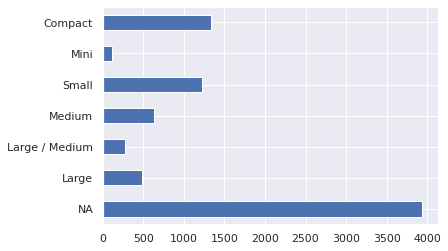

In [ ]:
# Plot the count of values per category for 'ProductSize' and 'YearMade', which are our
# two most important features.

p = valid_x_final['ProductSize'].value_counts(sort=False).plot.barh()
# Add a 'NA' category value, because all categorical values have been shifted by +1
# by the Databundle
c = ['NA'] + bb_app.db.convert_state_x['Category_ProductSize'].to_list()
plt.yticks(range(len(c)), c);

In [ ]:
print(c)

['Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']


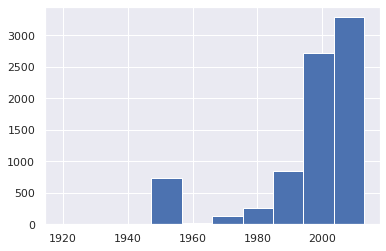

In [ ]:
ax = valid_x_final['YearMade'].hist()

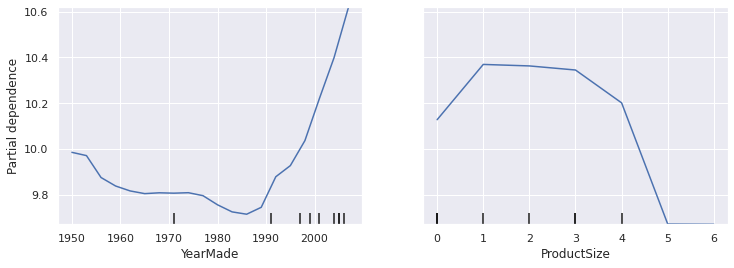

In [ ]:
# Create partial dependence plots to answer the question: if a row varied on nothing 
# other than the feature in question, how would it impact the dependent variable?
# For instance, how does YearMade impact sale price, all other things being equal?

# To do this, replace every single value in the YearMade column with 1950, and then 
# calculate the predicted sale price for every auction, and take the average over 
# all auctions. Then we do the same for 1951, 1952, and so forth until our final 
# year of 2011. 

# The way to think about this is - let's take the first row in the dataset. Now with
# this row, we keep all other values fixed, and just change one column viz. YearMade
# from 1950 till 2011, and calculate the predicted Sale Price as we vary the YearMade.
# Now repeat this for the second row in the dataset, and the third row, and so on.
#
# This isolates the effect of only YearMade (even if it does so by averaging over 
# some imagined records where we assign a YearMade value that might never actually 
# exist alongside some other values)

from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_x_final, ['YearMade','ProductSize'],  grid_resolution=20, ax=ax);

# The YearMade partial dependence plot, for years after 1990 has a nearly linear relationship between 
# year and price. Remember that our dependent variable is after taking the logarithm, so this means that in 
# practice there is an exponential increase in price. This is what we would expect: depreciation 
# is generally recognized as being a multiplicative factor over time, so, for a given sale date, 
# varying year made ought to show an exponential relationship with sale price.

# ProductSize partial plot is a bit concerning. It shows that the final group (for missing 
# values), has the lowest price. We need to find out why it's missing so often, and what that means.

### Model Interpretation - Tree Interpreter

In [ ]:
# For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?

# We can do this using the Tree Interpreter.
# 
# To calculate feature importances, the idea was to look at the contribution of each 
# variable to improving the model, at each branch of every tree, and then add up all 
# of these contributions per variable. That told us which columns were the most important
# predictors.
#
# Now, we can do exactly the same thing, but for just a single row of data. For instance, 
# let's say we are looking at some particular item at auction. Our model might predict 
# that this item will be very expensive, and we want to know why. So, we take that one 
# row of data and put it through the first decision tree, looking to see what split is 
# used at each point throughout the tree. For each split, we see what the increase or 
# decrease in the prediction is, compared to the parent node of the tree. We do this 
# for every tree, and add up the total change in importance by split variable.

!pip install treeinterpreter
!pip install waterfallcharts

import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

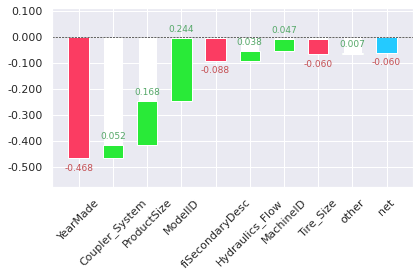

In [ ]:
# Pass in the first few rows of the validation set.
row = valid_x_final.iloc[:5]

# 'Prediction' is simply the prediction that the random forest makes. 'Bias' is the 
# prediction based on taking the mean of the dependent variable (i.e., the model 
# that is the root of every tree). This is sort-of the baseline model.
# 'Contributions' is the most interesting bit—it tells us the total change in 
# predicition due to each of the independent variables.
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

# Therefore, the sum of contributions plus bias must equal the prediction, for 
# each row. Check out the first row.
prediction[0], bias[0], contributions[0].sum()

# Visualise the contributions with a waterfall plot, which shows how the positive 
# and negative contributions from all the independent variables sum up to create 
# the final prediction, which is the righthand column labeled "net"
waterfall(valid_x_final.columns, contributions[0], threshold=0.08, rotation_value=45,formatting='{:,.3f}');

# For instance, this plot shows us that the first feature, YearMade resulted in a
# prediction with a -ve delta from the baseline 'bias' value. The second feature, Coupler_System
# resulted in a +ve delta, and so on. The final blue 'net' value is the cumulative net delta
# from all the feature deltas.

### Out-of-Domain Data

In [ ]:
# Random forests are not good at extrapolating their predictions for data values which 
# lie outside the range of values present in the training data. This is because a random 
# forest just averages the predictions of a number of trees. And a tree simply predicts 
# the average value of the rows in a leaf. Therefore, a tree and a random forest can 
# never predict values outside of the range of the training data.

# Therefore it is essential to ensure that your test data is distributed in the same 
# way as your training data. To check for this, with our validation data, we add one 
# more column to our dataset which is a flag that tells whether the row is in the 
# validation set or the training set. We then use that column as our dependent variable
# instead of our real dependent variable, and train a Random Forest to predict this
# flag ie. to predict whether a row is in the training set or the validation set.

# Combine our training and validation sets together
df_dom = pd.concat([train_x_final, valid_x_final])
# Create a flag which is False for training rows and True for validation rows
is_valid = np.array([0]*len(train_x_final) + [1] * len(valid_x_final))

# Use that flag as the dependent variable and fit the Random Forest. Now if the
# training and validation sets truly have similar distributions, then it would be
# impossible to tell them apart and the Random Forest would be no better than making
# a random 50-50 guess. On the other hand, if the distributions are not similar,
# the Random Forest would do better than a random guess.
m = rf(df_dom, is_valid)
# Check feature importance to see which columns are helping the Random Forest
# predict the difference between training and validation rows. If some columns
# have high importance, it means that the Random Forest is able to use those columns 
# to tell training and validation rows apart. 
rf_feat_importance(m, df_dom)[:6]

,cols,imp
5,saleElapsed,0.890717
10,SalesID,0.070155
12,MachineID,0.033638
0,YearMade,0.001710
4,ModelID,0.000888
7,Enclosure,0.000546


In [ ]:
# Based on the feature importance, there are three columns that differ significantly 
# between the training and validation sets: 
#   1) saleElapsed - this is not surprising because it represents the number of days 
#              between the start of the dataset and each row, and our training and
#              validation data has been split on the date.
#   2) SalesID - this suggests that identifiers for auction sales might increment over time.
#   3) MachineID - similarly, the identifiers for items sold at auctions might increment
#              over time

# Get a baseline value for the model's RMSE...
m = rf(train_x_final, train_y)
print('orig', m_rmse(m, valid_x_final, valid_y))

# ... and then see what RMSE we get after removing each column in turn
for c in ('SalesID','saleElapsed','MachineID'):
    m = rf(train_x_final.drop(c,axis=1), train_y)
    print(c, m_rmse(m, valid_x_final.drop(c,axis=1), valid_y))

orig 0.233027
SalesID 0.230699
saleElapsed 0.235724
MachineID 0.231255


In [ ]:
# Since the RMSE didn't drop much, let's try removing SalesID and MachineID

time_vars = ['SalesID','MachineID']
train_x_final_time = train_x_final.drop(time_vars, axis=1)
valid_x_final_time = valid_x_final.drop(time_vars, axis=1)

# Check accuracy again
m = rf(train_x_final_time, train_y)
m_rmse(m, valid_x_final_time, valid_y)

# The accuracy actually ends up improving!!

0.229444

### data_lib Junk

In [ ]:
  # ----------------------------
  # Convert all categorical variables to numeric category codes, using the 
  # Pandas Categorical data type
  # ----------------------------
  @df_process(save_res=True, use_fd=False)
  def to_cat(self, df, convert_state, in_train, cols=None, ordinal_vals={}, **kwargs):
    cols = cols if (cols is not None) else self._categorical_cols()

    for col in cols:
      # !!!!!!!!!!!
      if (False):
        # Temporarily convert the column to Pandas categorical data type in order to
        # get the category codes for training data. Pandas category codes start 
        # from 0, and -1 is used for NaN values. So we add 1 to all codes which means 
        # that NaN get a 0 value, and all other categories get shifted by 1.
        cat_df = df[col].astype('category')

        # Set the category value using the given order, if the values are 
        # ordinal ie. they have an intrinsic order
        if (col in ordinal_vals):
          vals = ordinal_vals[col]
          cat_df.cat.set_categories(vals, ordered=True, inplace=True)

        df[col] = cat_df.cat.codes + 1

        # Save away the category names for use with validation data
        convert_state[f'Category_{col}'] = cat_df.cat.categories
      elif (in_train):
        # !!!!!!!!
        if not is_categorical_dtype(df[col]):
          print (col)
          df[col] = df[col].astype('category')

        # Set the category value using the given order, if the values are 
        # ordinal ie. they have an intrinsic order
        if (col in ordinal_vals):
          vals = ordinal_vals[col]
          df[col].cat.set_categories(vals, ordered=True, inplace=True)

        convert_state[f'Category_{col}'] = df[col].cat.categories
        df[col] = df[col].cat.codes + 1
      else:
        # For validation and test data, use the same categories that were saved for
        # training data. Set the ordered flag if the column is ordinal.
        ordered = (col in ordinal_vals)
        cat_col = pd.Categorical(df[col], categories=convert_state[f'Category_{col}'], ordered=ordered)
        df[col] = cat_col.codes + 1

  # ----------------------------
  # Convert all categorical variables to the Pandas Categorical data type
  # ----------------------------
  @df_process(save_res=True, use_fd=False)
  def TEMP_to_cat(self, df, convert_state, in_train, cols=None, **kwargs):
    cols = cols if (cols is not None) else self._categorical_cols()

    for col in cols:
      if (in_train):
        # Convert the column to categorical type for training data and save away
        # the category names for use with validation data
        df[col] = df[col].astype('category').cat.as_ordered()
        convert_state[f'Category_{col}'] = df[col].cat.categories
      else:
        # For validation and test data, use the same categories that were saved for
        # training data
        df[col] = pd.Categorical(df[col], categories=convert_state[f'Category_{col}'], ordered=True)

  # ----------------------------
  # Return a numpy array of all the column values for the i-th row
  # ----------------------------
  @df_process(save_res=True, use_fd=False)
  def to_np(self, df, **kwargs):
    cat_cols, cont_cols = self._categorical_cols(), self._continuous_cols()
    all_cols = cat_cols + cont_cols + self._target_cols()

    # Check that there are no NaNs
    assert(df[cont_cols].isna().sum().sum() == 0)
    #assert(np.isfinite(df[cont_cols]).all().all())

    # Get code numbers for categorical columns and the numeric
    # value for all other columns
    def _getv(df, col):
      if (col in cat_cols):
        return df[col].cat.codes.values + 1
      else:
        return df[col].values

    # List of columns values for all columns. Make sure that all the
    # categorical columns are first, followed by all the continuous columns
    vals = [_getv(df, col) for col in all_cols if col in df.columns]

    # Convert list to numpy array
    arr = np.stack(vals, axis=1)

    # Convert to float if it isn't already
    if (not np.issubdtype(arr.dtype, float)):
      arr = arr.astype('float32')

    self.arr = arr
